In [41]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from copy import deepcopy
from scipy.spatial.distance import euclidean
import scipy.ndimage as sciim
from astropy.io import fits
from scipy.ndimage import label
import hcipy as hc
import matplotlib as mpl
import matplotlib.pyplot as plt

## Loading data 

In [43]:
datadir = '/Users/pueyo/Desktop/LUVOIRB/'
aperture_data = fits.getdata(os.path.join(datadir,'Pupil1.fits'))
apod_data = fits.getdata(os.path.join(datadir,'APOD.fits'))
DM2_Stop_data = fits.getdata(os.path.join(datadir,'DM2stop.fits'))
lyot_stop_data = fits.getdata(os.path.join(datadir,'LS.fits'))
DM1_data = fits.getdata(os.path.join(datadir,'surfDM1.fits'))
DM2_data = fits.getdata(os.path.join(datadir,'surfDM2.fits'))

## Parameters

In [45]:
nPup_arrays = apod_data.shape[0]
nPup_dms = DM1_data.shape[0]
nPup = 1000
D_pup = 0.048
samp_foc = 4
rad_foc = 36
wavelength = 500e-9
zDM = (D_pup/2)**2 / (wavelength * 549.1429)
bw = 0.1
n_wavelength = 11
num_actuators_across = 24
actuator_spacing = D_pup/num_actuators_across

## Dealing with stupidity of arrays being padded

In [46]:
apod_data_pad = np.pad(apod_data, np.int((nPup_dms- nPup_arrays)/2),mode='constant')
DM2Stop_data_pad = np.pad(DM2_Stop_data, np.int((nPup_dms- nPup_arrays-10)/2),mode='constant')
lyot_stop_data_pad = np.pad(lyot_stop_data, np.int((nPup_dms- nPup_arrays)/2),mode='constant')
aperture_data_pad = np.pad(aperture_data, np.int((nPup_dms- nPup_arrays)/2),mode='constant')
pupil_grid_real = hc.make_pupil_grid(nPup,D_pup)
pupil_grid_arrays = hc.make_pupil_grid(nPup*(nPup_arrays/nPup),D_pup*(nPup_arrays/nPup))
pupil_grid_dms = hc.make_pupil_grid(nPup*(nPup_dms/nPup),D_pup*(nPup_dms/nPup))
aperture = hc.Field(np.reshape(apod_data_pad,nPup_dms**2),pupil_grid_dms)
DM2_circle = hc.Field(np.reshape(DM2Stop_data_pad,nPup_dms**2),pupil_grid_dms)
lyot_mask = hc.Field(np.reshape(lyot_stop_data_pad,nPup_dms**2),pupil_grid_dms)
primary = hc.Field(np.reshape(aperture_data_pad,nPup_dms**2),pupil_grid_dms)
DM1 = hc.Field(np.reshape(DM1_data,nPup_dms**2),pupil_grid_dms)
DM2 = hc.Field(np.reshape(DM2_data,nPup_dms**2),pupil_grid_dms)
focal_grid = hc.make_focal_grid(
    samp_foc,
    rad_foc,
    pupil_diameter= D_pup,
    focal_length=1.,
    reference_wavelength= wavelength,
)

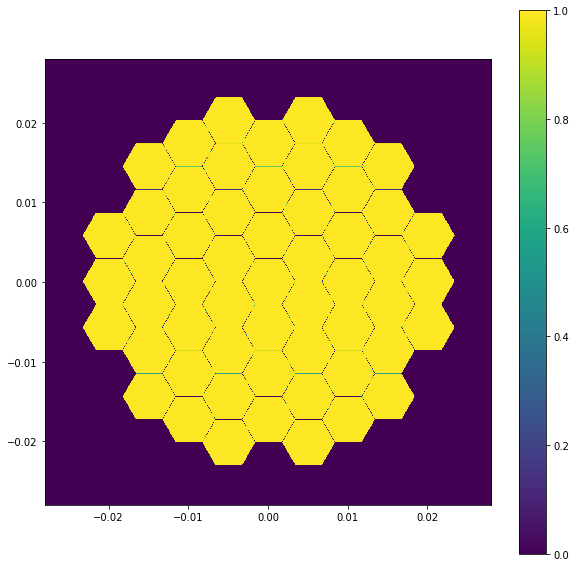

In [47]:
plt.figure(figsize=(10, 10))
hc.imshow_field(primary)
plt.colorbar()

## Propagators

In [30]:
prop = hc.FraunhoferPropagator(pupil_grid_dms, focal_grid)
fres_dms = hc.propagation.FresnelPropagator(pupil_grid_dms,zDM,num_oversampling = 1)
fres_dms_minus = hc.propagation.FresnelPropagator(pupil_grid_dms,-zDM, num_oversampling = 1)
charge = 6
coro = hc.VortexCoronagraph(pupil_grid_dms, charge,levels=4, scaling_factor=4)
lyot_stop = hc.Apodizer(lyot_mask)

## Actual code for propagation

In [31]:
wf = hc.Wavefront(primary*np.exp(4*1j*np.pi/wavelength*DM1),wavelength)
wf2 = fres_dms(wf)
wf3 = hc.Wavefront(wf2.electric_field*np.exp(4*1j*np.pi/wavelength*DM2)*DM2_circle,wavelength)
wf4 = fres_dms_minus(wf3)
wf5 = hc.Wavefront(wf4.electric_field*aperture,wavelength)
lyot_plane = coro.forward(wf5)
post_lyot_mask = lyot_stop(lyot_plane)
post_lyot_mask.wavelength = wavelength
img = prop(post_lyot_mask).intensity
img_ref = prop(wf4).intensity

## Displaying some planes

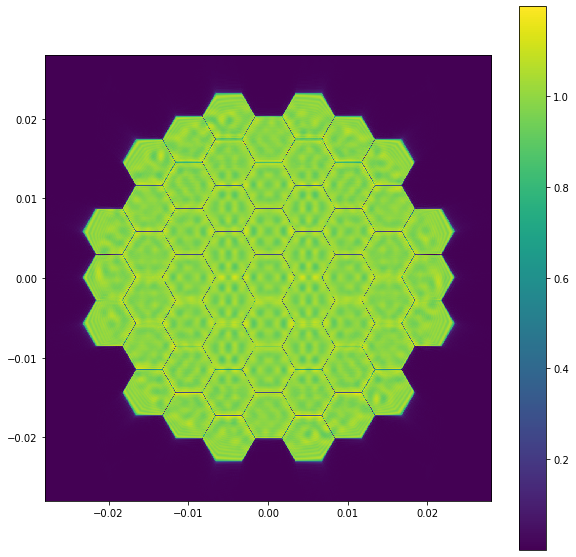

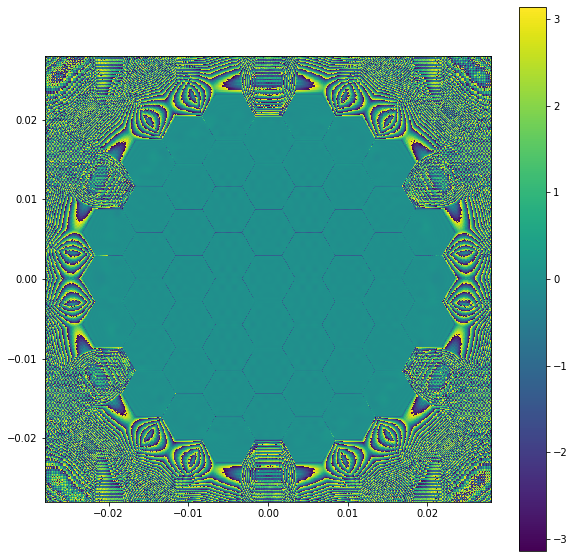

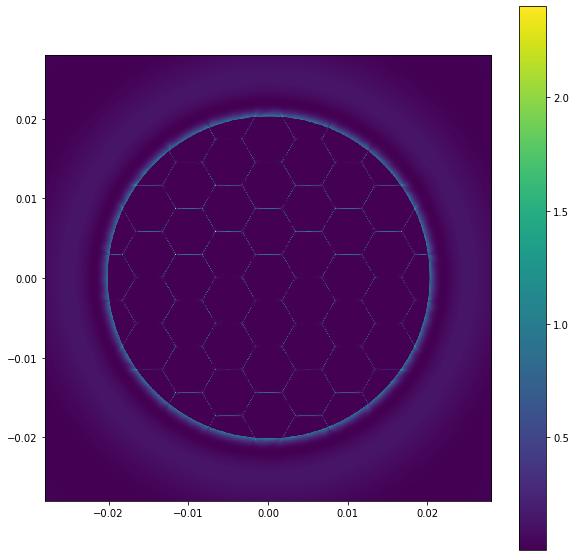

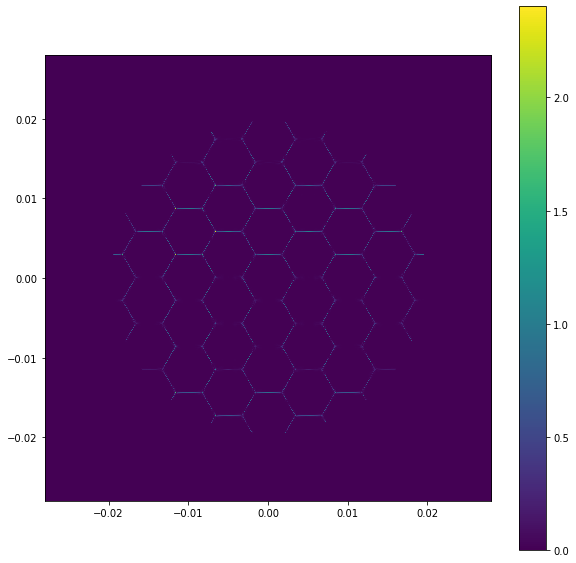

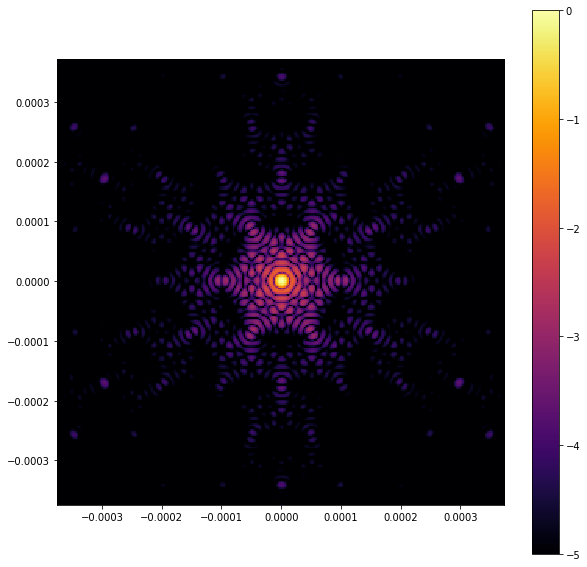

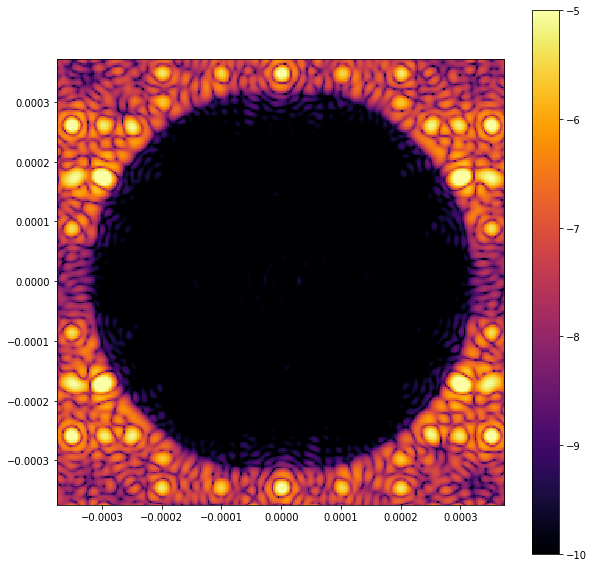

In [48]:
plt.figure(figsize=(10, 10))
hc.imshow_field(wf4.amplitude)
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 10))
hc.imshow_field(wf4.phase)
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 10))
hc.imshow_field(lyot_plane.intensity)
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 10))
hc.imshow_field(post_lyot_mask.intensity)
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 10))
hc.imshow_field(np.log10(img_ref / img_ref.max()), vmin=-5, cmap='inferno')
plt.colorbar()
plt.show()
plt.figure(figsize=(10, 10))
hc.imshow_field(np.log10(img / img_ref.max()), cmap='inferno',vmin = -10,vmax = -5)
plt.colorbar()
plt.show()

## Getting the segment locations from aperture

In [49]:
segments,num_segments = label(aperture_data > 0.154)# Fudged number based on what "looks right"
centroids = []
for i in range(num_segments):
    seg = (segments == (i + 1)).ravel()
    c_x = np.sum(seg * pupil_grid_arrays.x) / np.sum(seg)
    c_y = np.sum(seg * pupil_grid_arrays.y) / np.sum(seg)
    centroids.append(np.array([c_x, c_y]))
segment_circum_diameter = D_pup*(nPup_arrays/962)/8*1.024 # Fudged number based on what "looks right"
seg_pos_pre = np.transpose(np.array(centroids))
seg_pos = hc.CartesianGrid(hc.UnstructuredCoords(seg_pos_pre))

## Making segmented primary

In [37]:
def make_segment_zernike_primary(Nzernike):
    """Generate a zernike basis, up to Nzernike, for each segment.

            Parameters:
            ----------
            Nzernike : int
                Maximum order of each zernike on each segment

            --------
            self.sm: DeformableMirror
                Segmented mirror (primary) as a DM object
            """

    segment = hc.hexagonal_aperture(segment_circum_diameter, np.pi / 2)
    segment_sampled = hc.evaluate_supersampled(segment,pupil_grid_arrays, 1)
    aper2, segs2 = hc.make_segmented_aperture(segment,seg_pos, segment_transmissions=1, return_segments=True)
    luvoir_segmented_pattern = hc.evaluate_supersampled(aper2,pupil_grid_arrays, 1)
    seg_evaluated = []
    for seg_tmp in segs2:
        tmp_evaluated = hc.evaluate_supersampled(seg_tmp,pupil_grid_arrays, 1)
        seg_evaluated.append(tmp_evaluated)


    seg_num = 0
    mode_basis_local_zernike = hc.mode_basis.make_zernike_basis(Nzernike, segment_circum_diameter,pupil_grid_arrays.shifted(-seg_pos[seg_num]),
                                                                starting_mode=1,
                                                                ansi=False, radial_cutoff=True, use_cache=True)
    for qq in range(0, Nzernike):
        mode_basis_local_zernike._transformation_matrix[:, qq] = seg_evaluated[seg_num]*mode_basis_local_zernike._transformation_matrix[:, qq]
    for seg_num in range(1, 55):
        # print(seg_num)
        mode_basis_local_zernike_tmp = hc.mode_basis.make_zernike_basis(Nzernike,segment_circum_diameter,pupil_grid_arrays.shifted(-seg_pos[seg_num]),
                                                                        starting_mode=1,
                                                                        ansi=False, radial_cutoff=True,
                                                                        use_cache=True)
        for qq in range(0, Nzernike):
            mode_basis_local_zernike_tmp._transformation_matrix[:, qq] = seg_evaluated[seg_num] * mode_basis_local_zernike_tmp._transformation_matrix[:, qq]
        mode_basis_local_zernike.extend(mode_basis_local_zernike_tmp)

    sm = hc.optics.DeformableMirror(mode_basis_local_zernike)
    return sm

## Quick sanity check of segmented primary

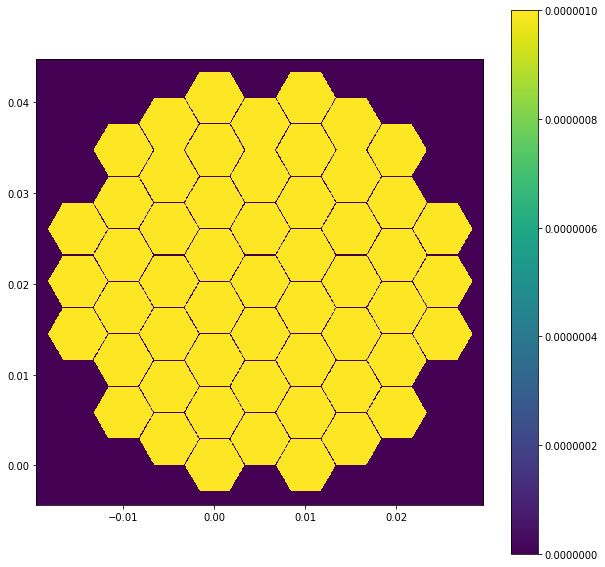

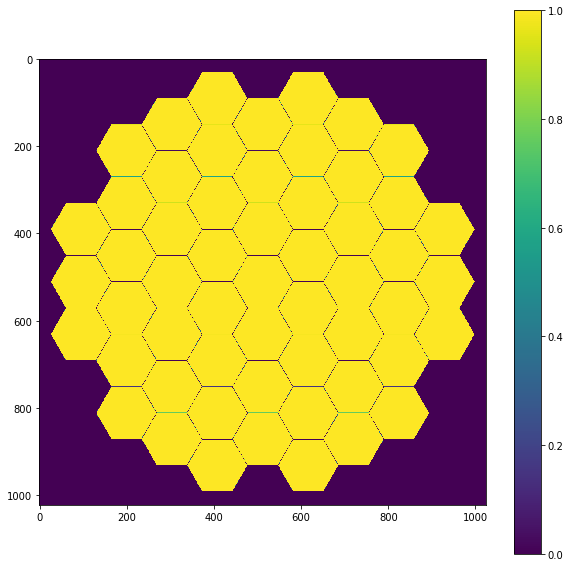

In [40]:
sm_test = make_segment_zernike_primary(1)
primary_small = hc.Field(np.reshape(aperture_data,nPup_arrays**2),pupil_grid_arrays)
input_wf = hc.Wavefront(primary_small,wavelength)
sm_test.actuators = np.ones(55)*wavelength
tmp_pupil = sm_test(input_wf)
plt.figure(figsize=(10, 10))
hc.imshow_field(sm_test.opd)
plt.colorbar()
plt.figure(figsize=(10, 10))
plt.imshow(aperture_data)
plt.colorbar()

## More tests need to be ran on segmented primary